In [2]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('retail_sales.db')
df = pd.read_csv('retail_sales_cleaned.csv')
df.to_sql('sales', conn, if_exists='replace', index=False)

# KPI con SQL
query = """
SELECT
    SUM([Total Amount]) AS total_revenue,
    COUNT(DISTINCT [Transaction ID]) AS total_transactions,
    SUM(Quantity) AS total_quantity,
    AVG([Total Amount]) AS avg_order_value
FROM sales
"""

pd.read_sql(query, conn)

,total_revenue,total_transactions,total_quantity,avg_order_value
0,456000,1000,2514,456.0


    year  month  revenue
0   2023      1    35450
1   2023      2    44060
2   2023      3    28990
3   2023      4    33870
4   2023      5    53150
5   2023      6    36715
6   2023      7    35465
7   2023      8    36960
8   2023      9    23620
9   2023     10    46580
10  2023     11    34920
11  2023     12    44690
12  2024      1     1530


<Axes: title={'center': 'Ricavi mensili'}, xlabel='month'>

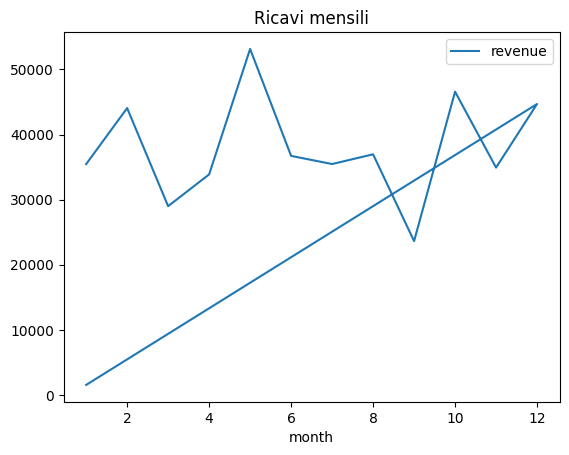

In [ ]:
# Analisi temporale
import matplotlib.pyplot as plt
import pandas as pd
query = """
SELECT
    year,
    month,
    SUM([Total Amount]) AS revenue
FROM sales
GROUP BY year, month
ORDER BY year, month
"""
print(pd.read_sql(query, conn)) 
monthly_sales = pd.read_sql(query, conn)
monthly_sales.plot(x='month', y='revenue', kind='line', title='Ricavi mensili')

In [4]:
# Vendite per categoria

query = """
SELECT
    [Product Category],
    SUM([Total Amount]) AS revenue
FROM sales
GROUP BY [Product Category]
ORDER BY revenue DESC
"""

print(pd.read_sql(query, conn))

  Product Category  revenue
0      Electronics   156905
1         Clothing   155580
2           Beauty   143515


In [5]:
# Vendite per cliente

query = """
SELECT
    [Customer ID],
    SUM([Total Amount]) AS customer_revenue
FROM sales
GROUP BY [Customer ID]
"""

pd.read_sql(query, conn)

,Customer ID,customer_revenue
0,CUST001,150
1,CUST002,1000
2,CUST003,30
3,CUST004,500
4,CUST005,100
...,...,...
995,CUST995,30
996,CUST996,50
997,CUST997,90
998,CUST998,100


In [8]:
# Vendite per genere
query = """
SELECT
    [Gender],
    SUM([Total Amount]) AS revenue
FROM sales
GROUP BY [Gender]
ORDER BY revenue DESC
"""
print(pd.read_sql(query, conn))
pct_male = pd.read_sql(query, conn)['revenue'][0] / pd.read_sql(query, conn)['revenue'].sum() * 100
print(f"Percentuale di vendite da clienti maschi: {pct_male:.2f}%")

   Gender  revenue
0  Female   232840
1    Male   223160
Percentuale di vendite da clienti maschi: 51.06%


In [13]:
# vendite per fasce d'età 
query = """
SELECT 
    CASE 
        WHEN [Age] BETWEEN 18 AND 25 THEN '18-25'
        WHEN [Age] BETWEEN 26 AND 35 THEN '26-35'
        WHEN [Age] BETWEEN 36 AND 45 THEN '36-50'
        ELSE 'Over 50'
    END AS age_group,
    SUM([Total Amount]) AS revenue
FROM sales
GROUP BY age_group
ORDER BY age_group ASC
"""
print(pd.read_sql(query, conn))

  age_group  revenue
0     18-25    84550
1     26-35    98480
2     36-50    91870
3   Over 50   181100


In [ ]:
#Distribuzione nella settimana 
query = """
SELECT 
    day_of_week AS Weekday,
    SUM([Total Amount]) AS revenue
FROM sales
GROUP BY [Weekday]
ORDER BY revenue DESC
"""
print(pd.read_sql(query, conn))

     Weekday  revenue
0   Saturday    78815
1     Monday    70250
2    Tuesday    69440
3     Friday    66290
4  Wednesday    58770
5     Sunday    58600
6   Thursday    53835


In [19]:
# Vendite per fascia di spesa 
query = """
WITH FasceSpesa AS (
    SELECT 
        CASE 
            WHEN [Total Amount] <= 100 THEN '0-100'
            WHEN [Total Amount] <= 250 THEN '101-250'
            WHEN [Total Amount] <= 500 THEN '251-500'
            WHEN [Total Amount] <= 1000 THEN '501-1000'
            WHEN [Total Amount] <= 2000 THEN '1001-2000'
            ELSE '2000+' 
        END AS fascia_spesa,
        [Total Amount]
    FROM sales
),
Aggregazione AS (
    SELECT 
        fascia_spesa,
        COUNT(*) AS numero_clienti,
        SUM([Total Amount]) AS totale_speso
    FROM FasceSpesa
    GROUP BY fascia_spesa
)
SELECT 
    fascia_spesa,
    numero_clienti,
    totale_speso,
    ROUND(CAST(numero_clienti AS FLOAT) / SUM(numero_clienti) OVER () * 100, 2) AS percentuale_clienti,
    ROUND(CAST(totale_speso AS FLOAT) / SUM(totale_speso) OVER () * 100, 2) AS percentuale_valore_totale
FROM Aggregazione
ORDER BY 
    CASE fascia_spesa
        WHEN '0-100' THEN 1
        WHEN '101-250' THEN 2
        WHEN '251-500' THEN 3
        WHEN '501-1000' THEN 4
        WHEN '1001-2000' THEN 5
        WHEN '2000+' THEN 6
    END;
    """
print(pd.read_sql(query, conn))

  fascia_spesa  numero_clienti  totale_speso  percentuale_clienti  \
0        0-100             457         29240                 45.7   
1      101-250             147         23860                 14.7   
2      251-500              97         39300                  9.7   
3     501-1000             146        125800                 14.6   
4    1001-2000             153        237800                 15.3   

   percentuale_valore_totale  
0                       6.41  
1                       5.23  
2                       8.62  
3                      27.59  
4                      52.15  


In [ ]:
# variazione percentuale mese su mese 
import statistics
query = """
WITH VenditeMensili AS (
    SELECT 
        year, 
        month, 
        SUM([Total Amount]) AS total_amount
    FROM sales
    GROUP BY year, month
),
MoM_Calculation AS (
    SELECT 
        year, 
        month, 
        total_amount,
        LAG(total_amount) OVER (ORDER BY year, month) AS total_amount_prev,
        -- Formula pct_change: (attuale - precedente) / precedente
        (total_amount - LAG(total_amount) OVER (ORDER BY year, month)) / 
        CAST(LAG(total_amount) OVER (ORDER BY year, month) AS FLOAT) AS mo_m_growth
    FROM VenditeMensili
)
SELECT * FROM MoM_Calculation;
"""
df = pd.read_sql(query, conn)
df['volatilita_mensile_globale'] = df['mo_m_growth'].std()
print(df)

# Calcolo della volatilità
volatilita_mensile = df['mo_m_growth'].std()

print(f"La volatilità media mensile è del: {volatilita_mensile}")

    year  month  total_amount  total_amount_prev  mo_m_growth  \
0   2023      1         35450                NaN          NaN   
1   2023      2         44060            35450.0     0.242877   
2   2023      3         28990            44060.0    -0.342034   
3   2023      4         33870            28990.0     0.168334   
4   2023      5         53150            33870.0     0.569235   
5   2023      6         36715            53150.0    -0.309219   
6   2023      7         35465            36715.0    -0.034046   
7   2023      8         36960            35465.0     0.042154   
8   2023      9         23620            36960.0    -0.360931   
9   2023     10         46580            23620.0     0.972058   
10  2023     11         34920            46580.0    -0.250322   
11  2023     12         44690            34920.0     0.279782   
12  2024      1          1530            44690.0    -0.965764   

    volatilita_mensile_globale  
0                      0.50233  
1                      

            revenue
Date               
2023-01-01     3600
2023-01-02     1765
2023-01-03      600
2023-01-04     1240
2023-01-05     1100


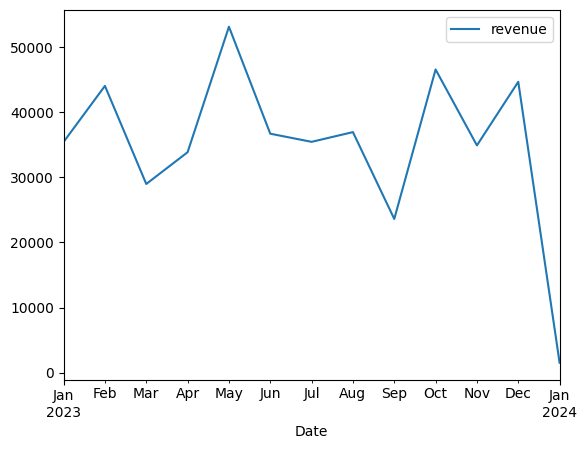

In [36]:
query = """
SELECT
    Date AS Date,
    SUM([Total Amount]) AS revenue
FROM retail
GROUP BY Date
ORDER BY Date
"""
ts = pd.read_sql(query, conn)
ts['Date'] = pd.to_datetime(ts['Date'])
ts = ts.set_index('Date')
print(ts.head())
ts_monthly = ts.resample('ME').sum()
ts_monthly.plot()
plt.show()

INSIGHT
- il 45% del volume dei clienti si collocano nella fascia di spesa più bassa.
- il 52% del valore della spesa però è concentrato nella fascia alto-spendente.
- la spesa è concentrata maggiormente nella fascia d'età 36-50 e prevalentemente nel settore elettronico; non si registrano differenze rilevanti per genere.
- La distribuzione nel tempo mostra un'alta volatilità (0,5) con forti shock nel breve periodo. L'andamento è atipico e non segue gli eventi di calendario (black friday, rally natalizio); servirebbero serie storiche per capire se la stagionalità normalizza i dati o se vi sono specifci eventi esogeni.
- Si riscontra inifine una marcata ciclicità settimanale con il picco massimo il sabato (€78.8k) e il minimo il giovedì (€53.8k), evidenziando una concentrazione degli acquisti nel weekend e una forte ripresa a inizio settimana.